## Análise de Cluster
### MBA em Data Science e Analytics USP ESALQ

**Prof Dr.** Wilson Tarantin Junior

**Aluna:** Luiza Batista Laquini

**Turma:** DSA 2024-1

### Bibliotecas e configurações

In [4]:
import pandas as pd
import matplotlib.pyplot as plt
from scipy.stats import zscore
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
import pingouin as pg
import plotly.express as px 

#import plotly.io as pio
#pio.renderers.default='browser'

import warnings
warnings.filterwarnings("ignore")

**Objetivos:**
- Agrupar os clientes de uma operadora de cartão de crédito
- Analisar os grupos de clientes mais e menos leais à marca (por meio do uso)

### Visualização dos dados

In [5]:
# Leitura dos dados
dados_cartao = pd.read_csv('cartao_credito.csv')
## Fonte: https://www.kaggle.com/datasets/aryashah2k/credit-card-customer-data

# Estrutura dos dados
print(dados_cartao.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 660 entries, 0 to 659
Data columns (total 7 columns):
 #   Column               Non-Null Count  Dtype
---  ------               --------------  -----
 0   Sl_No                660 non-null    int64
 1   Customer Key         660 non-null    int64
 2   Avg_Credit_Limit     660 non-null    int64
 3   Total_Credit_Cards   660 non-null    int64
 4   Total_visits_bank    660 non-null    int64
 5   Total_visits_online  660 non-null    int64
 6   Total_calls_made     660 non-null    int64
dtypes: int64(7)
memory usage: 36.2 KB
None


In [6]:
# Visualização de amostra da tabela
dados_cartao.head()

,Sl_No,Customer Key,Avg_Credit_Limit,Total_Credit_Cards,Total_visits_bank,Total_visits_online,Total_calls_made
0,1,87073,100000,2,1,1,0
1,2,38414,50000,3,0,10,9
2,3,17341,50000,7,1,3,4
3,4,40496,30000,5,1,1,4
4,5,47437,100000,6,0,12,3


In [8]:
# Estatísticas descritivas das variáveis quantitativas
cartao_cluster = dados_cartao.drop(columns=['Sl_No', 'Customer Key'])
tab_descritivas = cartao_cluster.describe().T
tab_descritivas

,count,mean,std,min,25%,50%,75%,max
Avg_Credit_Limit,660.0,34574.242424,37625.487804,3000.0,10000.0,18000.0,48000.0,200000.0
Total_Credit_Cards,660.0,4.706061,2.167835,1.0,3.0,5.0,6.0,10.0
Total_visits_bank,660.0,2.403030,1.631813,0.0,1.0,2.0,4.0,5.0
Total_visits_online,660.0,2.606061,2.935724,0.0,1.0,2.0,4.0,15.0
Total_calls_made,660.0,3.583333,2.865317,0.0,1.0,3.0,5.0,10.0


Necessário padronizar as variáveis antes da clusterização, pois temos escalas diferentes

In [10]:
# Aplicando Z-Score
cartao_pad = cartao_cluster.apply(zscore, ddof=1)

print('Média:')
print(round(cartao_pad.mean(), 3))
print('\nDesvio-Padrão:')
print(round(cartao_pad.std(), 3))

Média:
Avg_Credit_Limit       0.0
Total_Credit_Cards     0.0
Total_visits_bank      0.0
Total_visits_online    0.0
Total_calls_made      -0.0
dtype: float64

Desvio-Padrão:
Avg_Credit_Limit       1.0
Total_Credit_Cards     1.0
Total_visits_bank      1.0
Total_visits_online    1.0
Total_calls_made       1.0
dtype: float64


In [11]:
# Gráfico 3D das observações
fig = px.scatter_3d(cartao_pad, 
                    x='Avg_Credit_Limit', 
                    y='Total_Credit_Cards', 
                    z='Total_visits_bank')
fig.show()

#### Gráfico do Cotovelo

  File "c:\Users\madeinweb\Documents\GitHub\unsupervised-machine-learning\.venv\lib\site-packages\joblib\externals\loky\backend\context.py", line 282, in _count_physical_cores
    raise ValueError(f"found {cpu_count_physical} physical cores < 1")


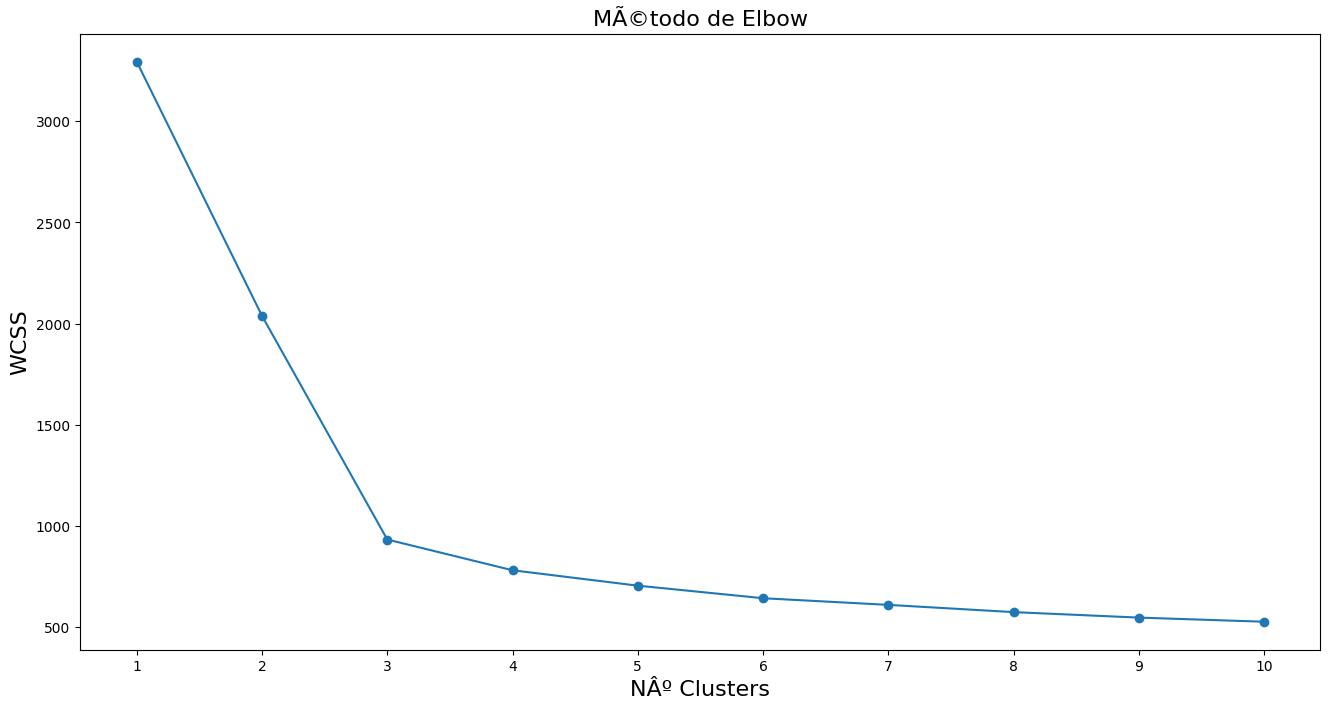

In [12]:
# Gráfico do cotovelo - para identificação da quantidade ideal de clusters
elbow = []
K = range(1,11) # ponto de parada pode ser parametrizado manualmente
for k in K:
    kmeanElbow = KMeans(n_clusters=k, init='random', random_state=100).fit(cartao_pad)
    elbow.append(kmeanElbow.inertia_)
    
plt.figure(figsize=(16,8))
plt.plot(K, elbow, marker='o')
plt.xlabel('NÂº Clusters', fontsize=16)
plt.xticks(range(1,11)) # ajustar range
plt.ylabel('WCSS', fontsize=16)
plt.title('MÃ©todo de Elbow', fontsize=16)
plt.show()

#### Gráfico de Silhueta

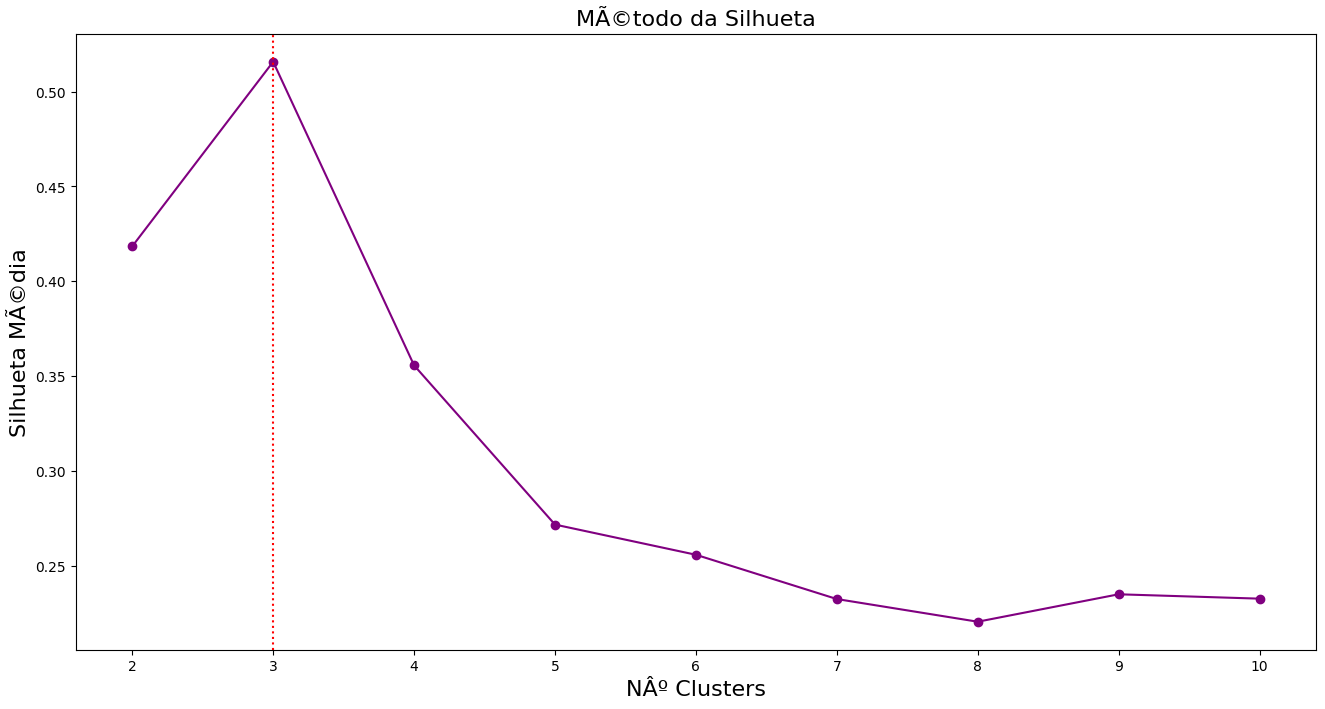

In [14]:
# Gráfico da silhueta - para identificação da quantidade ideal de clusters
silhueta = []
I = range(2,11) # ponto de parada pode ser parametrizado manualmente
for i in I: 
    kmeansSil = KMeans(n_clusters=i, init='random', random_state=100).fit(cartao_pad)
    silhueta.append(silhouette_score(cartao_pad, kmeansSil.labels_))
    
plt.figure(figsize=(16,8))
plt.plot(range(2, 11), silhueta, color = 'purple', marker='o')
plt.xlabel('Nº Clusters', fontsize=16)
plt.ylabel('Silhueta Média', fontsize=16)
plt.title('Método da Silhueta', fontsize=16)
plt.axvline(x = silhueta.index(max(silhueta))+2, linestyle = 'dotted', color = 'red') 
plt.show()

A partir do gráfico do cotovelo e do gráfico da silhueta concluímos que 3 clusters farão o melhor agrupamento 

### K-MEANS

In [16]:
# Treino
kmeans_final = KMeans(n_clusters = 3, init = 'random', random_state=100).fit(cartao_pad)

# Identificando os clusters
kmeans_clusters = kmeans_final.labels_
cartao_cluster['cluster_kmeans'] = kmeans_clusters
cartao_pad['cluster_kmeans'] = kmeans_clusters
cartao_cluster['cluster_kmeans'] = cartao_cluster['cluster_kmeans'].astype('category')
cartao_pad['cluster_kmeans'] = cartao_pad['cluster_kmeans'].astype('category')

cartao_pad.head()

,Avg_Credit_Limit,Total_Credit_Cards,Total_visits_bank,Total_visits_online,Total_calls_made,cluster_kmeans
0,1.738868,-1.248278,-0.859799,-0.547075,-1.250589,2
1,0.409982,-0.786988,-1.472614,2.518608,1.890425,1
2,0.409982,1.058171,-0.859799,0.134188,0.145417,2
3,-0.121573,0.135591,-0.859799,-0.547075,0.145417,2
4,1.738868,0.596881,-1.472614,3.199871,-0.203584,0


### ANOVA

Interpretação do output:

 cluster_kmeans MS: indica a variabilidade entre grupos<br>
 Within MS: indica a variabilidade dentro dos grupos<br>
 F: estatÃ­stica de teste (cluster_kmeans MS / Within MS)<br>
 p-unc: p-valor da estatÃ­stica F<br>
 se p-valor < 0.05: pelo menos um cluster apresenta mÃ©dia estatisticamente diferente dos demais

**Avg_Credit_Limit**

In [17]:
pg.anova(dv='Avg_Credit_Limit', 
         between='cluster_kmeans', 
         data=cartao_pad,
         detailed=True).T

,0,1
Source,cluster_kmeans,Within
SS,479.901385,179.098615
DF,2,657
MS,239.950692,0.272601
F,880.227938,NaN
p-unc,0.0,NaN
np2,0.728227,NaN


**Total_Credit_Cards**

In [18]:
pg.anova(dv='Total_Credit_Cards', 
         between='cluster_kmeans', 
         data=cartao_pad,
         detailed=True).T

,0,1
Source,cluster_kmeans,Within
SS,478.078715,180.921285
DF,2,657
MS,239.039358,0.275375
F,868.050755,NaN
p-unc,0.0,NaN
np2,0.725461,NaN


**Total_visits_bank**

In [19]:
pg.anova(dv='Total_visits_bank', 
         between='cluster_kmeans', 
         data=cartao_pad,
         detailed=True).T

,0,1
Source,cluster_kmeans,Within
SS,413.975651,245.024349
DF,2,657
MS,206.987826,0.372944
F,555.010154,NaN
p-unc,0.0,NaN
np2,0.628188,NaN


**Total_visits_online**

In [20]:
pg.anova(dv='Total_visits_online', 
         between='cluster_kmeans', 
         data=cartao_pad,
         detailed=True).T

,0,1
Source,cluster_kmeans,Within
SS,540.564886,118.435114
DF,2,657
MS,270.282443,0.180267
F,1499.348962,NaN
p-unc,0.0,NaN
np2,0.820281,NaN


**Total_calls_made**

In [21]:
pg.anova(dv='Total_calls_made', 
         between='cluster_kmeans', 
         data=cartao_pad,
         detailed=True).T

,0,1
Source,cluster_kmeans,Within
SS,450.849316,208.150684
DF,2,657
MS,225.424658,0.31682
F,711.523007,NaN
p-unc,0.0,NaN
np2,0.684142,NaN


### Gráficos 3D

Perspectiva 1

In [22]:
fig = px.scatter_3d(cartao_cluster, 
                    x='Avg_Credit_Limit', 
                    y='Total_Credit_Cards', 
                    z='Total_visits_online',
                    color='cluster_kmeans')
fig.show()

Perspectiva 2

In [23]:
fig = px.scatter_3d(cartao_cluster, 
                    x='Avg_Credit_Limit', 
                    y='Total_Credit_Cards', 
                    z='Total_visits_bank',
                    color='cluster_kmeans')
fig.show()

Perspectiva 3

In [24]:
fig = px.scatter_3d(cartao_cluster, 
                    x='Avg_Credit_Limit', 
                    y='Total_Credit_Cards', 
                    z='Total_calls_made',
                    color='cluster_kmeans')
fig.show()

### Características dos Clusters

Agrupando o banco de dados

In [26]:
# Agrupando os dados por cluster
cartao_grupo = cartao_cluster.groupby(by=['cluster_kmeans'])

# Estatísticas Descritivas
tab_desc_grupo = cartao_grupo.describe().T
tab_desc_grupo

cluster_kmeans                         0             1              2
Avg_Credit_Limit    count      50.000000    224.000000     386.000000
                    mean   141040.000000  12174.107143   33782.383420
                    std     34457.877272   5249.048524   22169.460696
                    min     84000.000000   3000.000000    5000.000000
                    25%    108750.000000   8000.000000   13000.000000
                    50%    145500.000000  12000.000000   31000.000000
                    75%    170000.000000  16000.000000   52000.000000
                    max    200000.000000  50000.000000  100000.000000
Total_Credit_Cards  count      50.000000    224.000000     386.000000
                    mean        8.740000      2.410714       5.515544
                    std         1.274715      1.100783       1.140069
                    min         5.000000      1.000000       2.000000
                    25%         8.000000      1.000000       4.000000
                    50%         9.000000      2.000000       6.000000
                    75%        10.000000      3.000000       6.000000
                    max        10.000000      4.000000       7.000000
Total_visits_bank   count      50.000000    224.000000     386.000000
                    mean        0.600000      0.933036       3.489637
                    std         0.494872      0.803567       1.135563
                    min         0.000000      0.000000       1.000000
                    25%         0.000000      0.000000       3.000000
                    50%         1.000000      1.000000       3.000000
                    75%         1.000000      2.000000       5.000000
                    max         1.000000      2.000000       5.000000
Total_visits_online count      50.000000    224.000000     386.000000
                    mean       10.900000      3.553571       0.981865
                    std         2.880264      1.218978       0.857167
                    min         6.000000      1.000000       0.000000
                    25%         8.000000      2.000000       0.000000
                    50%        11.000000      4.000000       1.000000
                    75%        13.000000      4.000000       2.000000
                    max        15.000000     10.000000       3.000000
Total_calls_made    count      50.000000    224.000000     386.000000
                    mean        1.080000      6.870536       2.000000
                    std         0.876915      1.990161       1.430648
                    min         0.000000      1.000000       0.000000
                    25%         0.000000      5.000000       1.000000
                    50%         1.000000      7.000000       2.000000
                    75%         2.000000      9.000000       3.000000
                    max         3.000000     10.000000       4.000000